# Build a machine learning workflow using Step Functions and SageMaker

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Build a machine learning workflow](#Build-a-machine-learning-workflow)


## Introduction

This notebook describes using the AWS Step Functions Data Science SDK to create and manage workflows. The Step Functions SDK is an open source library that allows data scientists to easily create and execute machine learning workflows using AWS Step Functions and Amazon SageMaker. For more information, see the following.
* [AWS Step Functions](https://aws.amazon.com/step-functions/)
* [AWS Step Functions Developer Guide](https://docs.aws.amazon.com/step-functions/latest/dg/welcome.html)
* [AWS Step Functions Data Science SDK](https://aws-step-functions-data-science-sdk.readthedocs.io)

In this notebook we will use the SDK to create steps, link them together to create a workflow, and execute the workflow in AWS Step Functions. The first tutorial shows how to create an ML pipeline workflow, and the second shows how to run multiple experiments in parallel.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade stepfunctions

## Setup

### Add a policy to your SageMaker role in IAM

**If you are running this notebook on an Amazon SageMaker notebook instance**, the IAM role assumed by your notebook instance needs permission to create and run workflows in AWS Step Functions. To provide this permission to the role, do the following.

1. Open the Amazon [SageMaker console](https://console.aws.amazon.com/sagemaker/). 
2. Select **Notebook instances** and choose the name of your notebook instance
3. Under **Permissions and encryption** select the role ARN to view the role on the IAM console
4. Choose **Attach policies** and search for `AWSStepFunctionsFullAccess`.
5. Select the check box next to `AWSStepFunctionsFullAccess` and choose **Attach policy**

If you are running this notebook in a local environment, the SDK will use your configured AWS CLI configuration. For more information, see [Configuring the AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html).

Next, create an execution role in IAM for Step Functions. 

### Create an execution role for Step Functions

You need an execution role so that you can create and execute workflows in Step Functions.

1. Go to the [IAM console](https://console.aws.amazon.com/iam/)
2. Select **Roles** and then **Create role**.
3. Under **Choose the service that will use this role** select **Step Functions**
4. Choose **Next** until you can enter a **Role name**
5. Enter a name such as `StepFunctionsWorkflowExecutionRole` and then select **Create role**


Attach a policy to the role you created. The following steps attach a policy that provides full access to Step Functions, however as a good practice you should only provide access to the resources you need.  

1. Under the **Permissions** tab, click **Add inline policy**
2. Enter the following in the **JSON** tab

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "sagemaker:CreateTransformJob",
                "sagemaker:DescribeTransformJob",
                "sagemaker:StopTransformJob",
                "sagemaker:CreateTrainingJob",
                "sagemaker:DescribeTrainingJob",
                "sagemaker:StopTrainingJob",
                "sagemaker:CreateHyperParameterTuningJob",
                "sagemaker:DescribeHyperParameterTuningJob",
                "sagemaker:StopHyperParameterTuningJob",
                "sagemaker:CreateModel",
                "sagemaker:CreateEndpointConfig",
                "sagemaker:CreateEndpoint",
                "sagemaker:DeleteEndpointConfig",
                "sagemaker:DeleteEndpoint",
                "sagemaker:UpdateEndpoint",
                "sagemaker:ListTags",
                "lambda:InvokeFunction",
                "sqs:SendMessage",
                "sns:Publish",
                "ecs:RunTask",
                "ecs:StopTask",
                "ecs:DescribeTasks",
                "dynamodb:GetItem",
                "dynamodb:PutItem",
                "dynamodb:UpdateItem",
                "dynamodb:DeleteItem",
                "batch:SubmitJob",
                "batch:DescribeJobs",
                "batch:TerminateJob",
                "glue:StartJobRun",
                "glue:GetJobRun",
                "glue:GetJobRuns",
                "glue:BatchStopJobRun"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:PassRole"
            ],
            "Resource": "*",
            "Condition": {
                "StringEquals": {
                    "iam:PassedToService": "sagemaker.amazonaws.com"
                }
            }
        },
        {
            "Effect": "Allow",
            "Action": [
                "events:PutTargets",
                "events:PutRule",
                "events:DescribeRule"
            ],
            "Resource": [
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTrainingJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTransformJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTuningJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForECSTaskRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForBatchJobsRule"
            ]
        }
    ]
}
```

3. Choose **Review policy** and give the policy a name such as `StepFunctionsWorkflowExecutionPolicy`
4. Choose **Create policy**. You will be redirected to the details page for the role.
5. Copy the **Role ARN** at the top of the **Summary**

### Configure execution roles

In [ ]:
import sagemaker

# SageMaker Execution Role
# You can use sagemaker.get_execution_role() if running inside sagemaker's notebook instance
sagemaker_execution_role = sagemaker.get_execution_role() #Replace with ARN if not in an AWS SageMaker notebook

# paste the StepFunctionsWorkflowExecutionRole ARN from above
workflow_execution_role = "<execution-role-arn>" 

### Import the required modules

In [ ]:
import boto3
import sagemaker
import time
import random
import uuid
import logging
import stepfunctions
import io
import random

from sagemaker.amazon.amazon_estimator import get_image_uri
from stepfunctions import steps
from stepfunctions.steps import TrainingStep, ModelStep, TransformStep
from stepfunctions.inputs import ExecutionInput
from stepfunctions.workflow import Workflow
from stepfunctions.template import TrainingPipeline
from stepfunctions.template.utils import replace_parameters_with_jsonpath

session = sagemaker.Session()
stepfunctions.set_stream_logger(level=logging.INFO)

region = boto3.Session().region_name
bucket = session.default_bucket()
prefix = 'sagemaker/DEMO-xgboost-regression'
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region, bucket)

### Prepare the dataset

The following cell defines utility methods to split a dataset into train, validation, and test datasets. It then defines methods to upload them to an Amazon S3 bucket.

In [ ]:
def data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST):
    data = [l for l in open(FILE_DATA, 'r')]
    train_file = open(FILE_TRAIN, 'w')
    valid_file = open(FILE_VALIDATION, 'w')
    tests_file = open(FILE_TEST, 'w')

    num_of_data = len(data)
    num_train = int((PERCENT_TRAIN/100.0)*num_of_data)
    num_valid = int((PERCENT_VALIDATION/100.0)*num_of_data)
    num_tests = int((PERCENT_TEST/100.0)*num_of_data)

    data_fractions = [num_train, num_valid, num_tests]
    split_data = [[],[],[]]

    rand_data_ind = 0

    for split_ind, fraction in enumerate(data_fractions):
        for i in range(fraction):
            rand_data_ind = random.randint(0, len(data)-1)
            split_data[split_ind].append(data[rand_data_ind])
            data.pop(rand_data_ind)

    for l in split_data[0]:
        train_file.write(l)

    for l in split_data[1]:
        valid_file.write(l)

    for l in split_data[2]:
        tests_file.write(l)

    train_file.close()
    valid_file.close()
    tests_file.close()

def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

This notebook uses the XGBoost algorithm to train and host a regression model. We use the [Abalone data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) originally from the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone). More details about the original dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names).  In the libsvm converted [version](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html), the nominal feature (Male/Female/Infant) has been converted into a real valued feature. Age of abalone is to be predicted from eight physical measurements.  

In [ ]:
try: #python3
    from urllib.request import urlretrieve
except: #python2
    from urllib import urlretrieve
    
# Load the dataset
FILE_DATA = 'abalone'
urlretrieve("https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/abalone", FILE_DATA)

#split the downloaded data into train/test/validation files
FILE_TRAIN = 'abalone.train'
FILE_VALIDATION = 'abalone.validation'
FILE_TEST = 'abalone.test'
PERCENT_TRAIN = 70
PERCENT_VALIDATION = 15
PERCENT_TEST = 15
data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST)

#upload the files to the S3 bucket
upload_to_s3(bucket, 'train', FILE_TRAIN)
upload_to_s3(bucket, 'validation', FILE_VALIDATION)
upload_to_s3(bucket, 'test', FILE_TEST)

train_s3_file = bucket_path + "/" + prefix + '/train'
validation_s3_file = bucket_path + "/" + prefix + '/validation'
test_s3_file = bucket_path + "/" + prefix + '/test'

### Configure the AWS Sagemaker estimator

In [ ]:
xgb = sagemaker.estimator.Estimator(
    get_image_uri(region, 'xgboost'),
    sagemaker_execution_role, 
    train_instance_count = 1, 
    train_instance_type = 'ml.m4.4xlarge',
    train_volume_size = 5,
    output_path = bucket_path + "/" + prefix + "/single-xgboost",
    sagemaker_session = session
)

xgb.set_hyperparameters(
    objective = 'reg:linear',
    num_round = 50,
    max_depth = 5,
    eta = 0.2,
    gamme = 4,
    min_child_weight = 6,
    subsample = 0.7,
    silent = 0
)


## Build a machine learning workflow

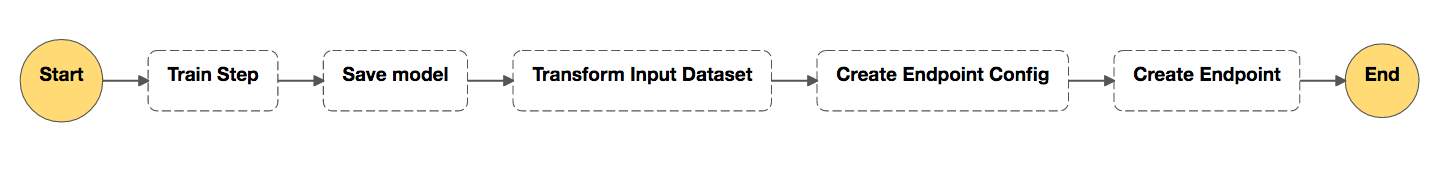

You can use a workflow to create a machine learning pipeline. The AWS Data Science Workflows SDK provides several AWS SageMaker workflow steps that you can use to construct an ML pipeline. In this tutorial you will use the Train and Transform steps.

* [**TrainingStep**](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.TrainingStep) - Starts a Sagemaker training job and outputs the model artifacts to S3.
* [**ModelStep**](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.ModelStep) - Creates a model on SageMaker using the model artifacts from S3.
* [**TransformStep**](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.TransformStep) - Starts a SageMaker transform job
* [**EndpointConfigStep**](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.EndpointConfigStep) - Defines an endpoint configuration on SageMaker.
* [**EndpointStep**](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.EndpointStep) - Deploys the trained model to the configured endpoint.

### Define the input schema for a workflow execution

The [**ExecutionInput**](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/placeholders.html#stepfunctions.inputs.ExecutionInput) API defines the options to dynamically pass information to a workflow at runtime.

The following cell defines the fields that must be passed to your workflow when starting an execution.

While the workflow is usually static after it is defined, you may want to pass values dynamically that are used by steps in your workflow. To help with this, the SDK provides a way to create placeholders when you define your workflow. These placeholders can be dynamically assigned values when you execute your workflow.

ExecutionInput values are accessible to each step of your workflow. You have the ability to define a schema for this placeholder collection, as shown in the cell below. When you execute your workflow the SDK will verify if the dynamic input conforms to the schema you defined.

In [ ]:
# SageMaker expects unique names for each job, model and endpoint. 
# If these names are not unique the execution will fail. Pass these
# dynamically for each execution using placeholders.
execution_input = ExecutionInput(schema={
    'JobName': str, 
    'ModelName': str,
    'EndpointName': str
})

### Create the training step 

In the following cell we create the training step and pass the estimator we defined above. See  [TrainingStep](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.TrainingStep) in the AWS Step Functions Data Science SDK documentation.

In [ ]:
training_step = steps.TrainingStep(
    'Train Step', 
    estimator=xgb,
    data={
        'train': sagemaker.s3_input(train_s3_file, content_type='libsvm'),
        'validation': sagemaker.s3_input(validation_s3_file, content_type='libsvm')
    },
    job_name=execution_input['JobName']  
)

### Create the model step 

In the following cell we define a model step that will create a model in SageMaker using the artifacts created during the TrainingStep. See  [ModelStep](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.ModelStep) in the AWS Step Functions Data Science SDK documentation.

The model creation step typically follows the training step. The Step Functions SDK provides the [get_expected_model](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.TrainingStep.get_expected_model) method in the TrainingStep class to provide a reference for the trained model artifacts. Please note that this method is only useful when the ModelStep directly follows the TrainingStep.

In [ ]:
model_step = steps.ModelStep(
    'Save model',
    model=training_step.get_expected_model(),
    model_name=execution_input['ModelName']  
)

### Create the transform step

In the following cell we create the transform step. See  [TransformStep](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.TransformStep) in the AWS Step Functions Data Science SDK documentation.

In [ ]:
transform_step = steps.TransformStep(
    'Transform Input Dataset',
    transformer=xgb.transformer(
        instance_count=1,
        instance_type='ml.m5.large'
    ),
    job_name=execution_input['JobName'],     
    model_name=execution_input['ModelName'], 
    data=test_s3_file,
    content_type='text/libsvm'
)

### Create an endpoint configuration step

In the following cell we create an endpoint configuration step. See [EndpointConfigStep](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.EndpointConfigStep) in the AWS Step Functions Data Science SDK documentation.



In [ ]:
endpoint_config_step = steps.EndpointConfigStep(
    "Create Endpoint Config",
    endpoint_config_name=execution_input['ModelName'],
    model_name=execution_input['ModelName'],
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

### Create an endpoint

In the following cell we create a step to deploy the trained model to an endpoint in AWS SageMaker. See [EndpointStep](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.sagemaker.EndpointStep) in the AWS Step Functions Data Science SDK documentation.

In [ ]:
endpoint_step = steps.EndpointStep(
    "Create Endpoint",
    endpoint_name=execution_input['EndpointName'],
    endpoint_config_name=execution_input['ModelName']
)

### Chain together steps for your workflow

Create your workflow definition by chaining the steps together. See [Chain](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/sagemaker.html#stepfunctions.steps.states.Chain) in the AWS Step Functions Data Science SDK documentation.

In [ ]:
workflow_definition = steps.Chain([
    training_step,
    model_step,
    transform_step,
    endpoint_config_step,
    endpoint_step
])

Create your workflow using the workflow definition above, and render the graph with [render_graph](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Workflow.render_graph).

In [ ]:
workflow = Workflow(
    name='MyTrainTransformDeploy_v1',
    definition=workflow_definition,
    role=workflow_execution_role,
    execution_input=execution_input
)

In [ ]:
workflow.render_graph()

Create the workflow in AWS Step Functions with [create](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Workflow.create).

In [ ]:
workflow.create()

Run the workflow with [execute](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Workflow.execute).

In [ ]:
execution = workflow.execute(
    inputs={
        'JobName': 'regression-{}'.format(uuid.uuid1().hex), # Each Sagemaker Job requires a unique name
        'ModelName': 'regression-{}'.format(uuid.uuid1().hex), # Each Model requires a unique name,
        'EndpointName': 'regression-{}'.format(uuid.uuid1().hex) # Each Endpoint requires a unique name,
    }
)

Render workflow progress with the [render_progress](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Execution.render_progress).

This generates a snapshot of the current state of your workflow as it executes. This is a static image. Run the cell again to check progress. 

In [ ]:
execution.render_progress()

Use [list_events](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Execution.list_events) to list all events in the workflow execution.

In [ ]:
execution.list_events(html=True)

Use [list_executions](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Workflow.list_executions) to list all executions for a specific workflow.

In [ ]:
workflow.list_executions(html=True)

Use [list_workflows](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/workflow.html#stepfunctions.workflow.Workflow.list_workflows) to list all workflows in your AWS account.

In [ ]:
Workflow.list_workflows(html=True)

---